In [ ]:
!pipwin install shapely
!pipwin install gdal
!pipwin install fiona
!pipwin install pyproj
!pipwin install six
!pipwin install rtree
!pipwin install geopandas
!pip install pipwin

In [10]:
#import statements
import datetime
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.animation as manimation
from matplotlib.animation import FFMpegWriter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import ipywidgets as widgets
from ipywidgets import interactive
#from keypass import NOAA_api
import time
import pylab as pl
import cv2
from IPython import display
import os
import geopandas as gpd
from functools import partial
import fiona
import pyproj

### Variable definitions

https://essd.copernicus.org/preprints/essd-2020-165/essd-2020-165.pdf


![image.png](https://drive.google.com/uc?id=1u1kiqDopkgnPwQWhLDEzWMQ3cqJ0AcT2)
![image.png](https://drive.google.com/uc?id=1eVptVUZIYySmqVLUVajEWiNUaWmaOcPG)


[1] A. Olsen et al., “GLODAPv2.2020 – the second update of GLODAPv2,” Oceanography – Chemical, preprint, Jul. 2020. doi: 10.5194/essd-2020-165.


## LOAD CSVs

In [2]:
arr = os.listdir('C:\\Users\\ossan\\DATA606\\DATA')
location = 'C:\\Users\\ossan\\DATA606\\DATA\\'
ARCTIC=arr[2]
ATLANTIC=arr[3]
INDIAN=arr[4]
MERGED = arr[5]
PACIFIC = arr[6]

## FILTER GOOD/BAD DATA

The datasource has definitions of data quality flags. Most columns include a column ending in 'f' denoting the quality flag for the data.  

https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.nodc:0210813

#### WOCE quality control flags 

<table>
  <thead>
    <tr>
      <th>Value</th>
      <th>Definition</th>
    </tr>
  </thead>
  <tbody>
    <tr>
        <td>Interpolated</td>
      <td>0</td>
    </tr>
       <tr>
      <td>Good Value</td>
      <td>2</td>
    </tr>
    <tr>
        <td>Bad</td>
      <td>9</td>
    </tr>
  </tbody>
</table>


### Get Counts of WOCE data flags to clean

- function q 
- note all columns ening in 'f' as QC flag 

### Set all "bad" values as np.nan and add column with ocean region

- Using quality columns and data columns from function "q"
- Dataset has been precleaned but just going through the exercise before dropping data quality columns

In [3]:
#load in all csvs 
ART = pd.read_csv(location + ARCTIC)
ATL = pd.read_csv(location + ATLANTIC)
IND = pd.read_csv(location + INDIAN)
PAC = pd.read_csv(location + PACIFIC)

In [4]:
M = pd.concat([ART,ATL,IND,PAC])
print(M.shape)

#all that are not missing values 
g=M[(M['h3err']!=-9999) | (M['he3err']!=-9999) | (M['c14err']!=-9999)| (M['heerr']!=-9999)| (M['neonerr']!=-9999)]


print('\n percent of rows with counting errors ')
print(len(g)/(M.shape[0])*100)

(1255056, 105)

 percent of rows with counting errors 
5.645724174857536


In [5]:
M.iloc[350000:1600000,80:90]

,c14err,h3,h3f,h3err,he3,he3f,he3err,he,hef,heerr
214611,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0
214612,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0
214613,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0
214614,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0
214615,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0
...,...,...,...,...,...,...,...,...,...,...
510682,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0
510683,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0
510684,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0
510685,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9.0,-9999.0


In [6]:
ART

#q is funtion to return counts of WOCE data point flags 

def q(df,oc):
    qualityCols,good,datacolumns = [],[],[] #set up array 
    for i in df.columns: #get the flag columns from dataframe 
        if i.endswith('f'): 
            qualityCols.append(i)
    for x in qualityCols: 
        datacolumns.append(x[0:(len(x)-1)])
    
    for c in qualityCols: #for each flag return counts 
        good.append(df[c].value_counts().rename_axis('unique_values').reset_index(name='counts'))
        
    a=0
    for x in good: #add the column name to the counts 
        x['Column'] = qualityCols[a] 
        a = a+1
    dfCounts = pd.concat(good) #concat list to dataframe 
    dfCounts=dfCounts.pivot(index='Column', columns='unique_values', values=['counts'])
    dfCounts.columns=dfCounts.columns.get_level_values(1) #drop level 
    dfCounts.reset_index(inplace=True) #make index become label      
    dfCounts['Ocean'] = oc
    return qualityCols,dfCounts,datacolumns #return the flag columns and the counts of flags 


#function to set bad quality values to NAN 
def setNAN(df,QualCol,DataCol,ocean):
    a= 0 #set count of data columns corresponding to qualifty columns 
    for QC in QualCol: # if the quality is good keep otherwise np.nan
        df[DataCol[a]] = np.where(df[QC]==2.0,df[DataCol[a]], np.nan)
        a = a+1
    for q in QualCol: #drop teh quality columns 
        
        df.drop(q, axis=1, inplace = True)
    df['Ocean Region'] = ocean #set the ocean region so concat later 
    print('dropped ' + str(len(QualCol)) + ' quality flag columns')
    return df
        

__Checking qc of dataset using above functions__

In [7]:
counts = [] #list of bad value couns 

#ARCTIC
QualCol,QCounts,DataCol = q(ART,'Arctic') ; counts.append(QCounts)
ArcticOcean = setNAN(ART,QualCol,DataCol,'Arctic')
#ATLANTIC 
QualCol,QCounts,DataCol = q(ATL,'Atlantic'); counts.append(QCounts)
AtlanticOcean = setNAN(ATL,QualCol,DataCol,'Atlantic')
#INDIAN
QualCol,QCounts,DataCol = q(IND,'Indian'); counts.append(QCounts)
IndianOcean = setNAN(IND,QualCol,DataCol,'Indian')
#PACIFIC
QualCol,QCounts,DataCol = q(PAC,'Pacific'); counts.append(QCounts)
PacificOcean = setNAN(PAC,QualCol,DataCol,'Pacific')

dropped 29 quality flag columns
dropped 29 quality flag columns
dropped 29 quality flag columns
dropped 29 quality flag columns


__Drop the rest of the quality check columns ending in 'err' or 'qc'__

- The 'err' columns refer to counting error, which is the statistical error in the [photon] measurements. The counting error is a representation of the error range and confidence level of the measurement, dependent on the counts recorded during a scientific reading. The percent of rows with a counting error value for either C14, H, He, or Ne is ~ 6%. 

- The 'qc' is a secondary check by the dataset owners' to "identify and correct any significant biases in the data from the 116 new cruises relative to GLODAPv2, while retaining any signal due to time changes"

#### Limits on adjustments for secondary QC evaluations [from dataset owners]


<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Minimum adjustment</th>
    </tr>
  </thead>
  <tbody>
    <tr>
        <td>Salinity</td>
      <td>0.005</td>
    </tr>
       <tr>
      <td>Oxygen</td>
      <td>1%</td>
    </tr>
    <tr>
        <td>Nutrients</td>
      <td>2%</td>
    </tr>
      <tr>
        <td>TCO$_2$</td>
      <td>4 $\mu$mol kg$^{-1}$</td>
    </tr>
      <tr>
        <td>TAlk</td>
      <td>4 $\mu$mol kg$^{-1}$</td>
    </tr>
        <tr>
        <td>pH</td>
      <td>0.01</td>
    </tr>
        <tr>
        <td>CFCs</td>
      <td>5%</td>
    </tr>
  </tbody>
</table>

#### Secondary QC quality control flags [from dataset owners]

<table>
  <thead>
    <tr>
      <th>Value</th>
      <th>Definition</th>
    </tr>
  </thead>
  <tbody>
    <tr>
        <td>Missing</td>
      <td>-999</td>
    </tr>
       <tr>
      <td>Full secondary QC Completed</td>
      <td>1</td>
    </tr>
    <tr>
        <td>Secondary QC not completed</td>
      <td>0</td>
    </tr>
  </tbody>
</table>

In [8]:
def droperr(df):
    c=[]
    coutner = 0
    for i in df.columns: #get the flag columns from dataframe 
        if i.endswith('err') or i.endswith('qc'):
            df.drop(i,axis=1,inplace=True)
            coutner = coutner +1 
    print('dropped ' +str(coutner)+' quality flag columns')
droperr(ArcticOcean)
droperr(IndianOcean)
droperr(AtlanticOcean)
droperr(PacificOcean)

ArcticOcean.columns

dropped 18 quality flag columns
dropped 18 quality flag columns
dropped 18 quality flag columns
dropped 18 quality flag columns


Index(['cruise', 'station', 'cast', 'year', 'month', 'day', 'hour', 'minute',
       'latitude', 'longitude', 'bottomdepth', 'maxsampdepth', 'bottle',
       'pressure', 'depth', 'temperature', 'theta', 'salinity', 'sigma0',
       'sigma1', 'sigma2', 'sigma3', 'sigma4', 'gamma', 'oxygen', 'aou',
       'nitrate', 'nitrite', 'silicate', 'phosphate', 'tco2', 'talk', 'fco2',
       'fco2temp', 'phts25p0', 'phtsinsitutp', 'cfc11', 'pcfc11', 'cfc12',
       'pcfc12', 'cfc113', 'pcfc113', 'ccl4', 'pccl4', 'sf6', 'psf6', 'c13',
       'c14', 'h3', 'he3', 'he', 'neon', 'o18', 'toc', 'doc', 'don', 'tdn',
       'chla', 'Ocean Region'],
      dtype='object')

### concant the counts of the good and bad data for each ocean

In [9]:
#get total of the 
TotalCounts = pd.concat(counts)
TotalCounts.columns=['Column','Interpolated','Good','Bad','Ocean']
TotalCounts['% Good or Interpolated Values'] = (TotalCounts.Good.fillna(0)+TotalCounts.Interpolated.fillna(0))/( TotalCounts.Good.fillna(0)+
                    TotalCounts.Interpolated.fillna(0)+TotalCounts.Bad)*100

In [10]:
TotalCounts

,Column,Interpolated,Good,Bad,Ocean,% Good or Interpolated Values
0,aouf,NaN,93677.0,41712.0,Arctic,69.190998
1,c13f,NaN,734.0,134655.0,Arctic,0.542142
2,c14f,NaN,395.0,134994.0,Arctic,0.291752
3,ccl4f,NaN,11787.0,123602.0,Arctic,8.706025
4,cfc113f,NaN,17523.0,117866.0,Arctic,12.942706
...,...,...,...,...,...,...
24,silicatef,20394.0,413510.0,76783.0,Pacific,84.964763
25,talkf,17338.0,162029.0,331320.0,Pacific,35.122688
26,tco2f,3866.0,191816.0,315005.0,Pacific,38.317404
27,tdnf,NaN,11661.0,499026.0,Pacific,2.283395


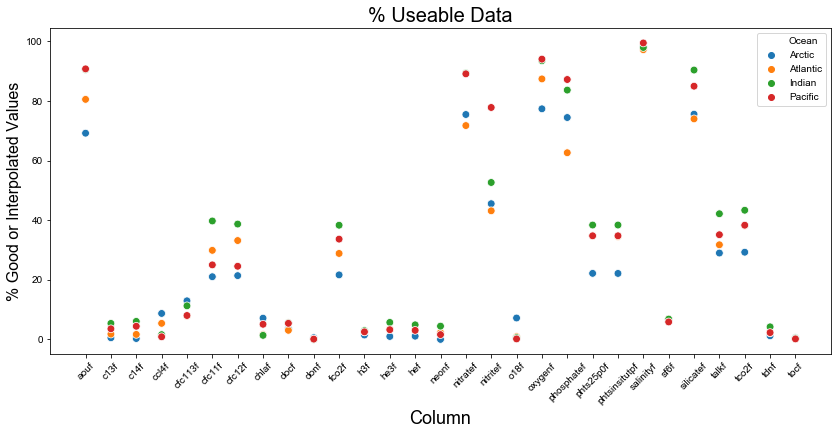

In [11]:
plt.figure(figsize=(14, 6))
ax = sns.scatterplot(x="Column", y="% Good or Interpolated Values", hue="Ocean",s = 60,
                     data=TotalCounts)

plt.xticks(rotation=45)

plt.title('% Useable Data', fontsize=20)
plt.xlabel('Column', fontsize=18)
plt.ylabel('% Good or Interpolated Values', fontsize=16)
sns.set(style='darkgrid',)
plt.show()

#### Concat to one dataframe and save as csv for easier loading later 

In [ ]:
MERGED = pd.concat([ArcticOcean,IndianOcean,AtlanticOcean,PacificOcean])
MERGED.to_csv('C:\\Users\\ossan\\DATA606\\DATA\\mergedOceans_droppedQCcolumns.csv',index=False)

### Cleaned data with unnecessary QC olumns dropped loaded in now 

__Abbreviated Data Column Names__
<table>
  <thead>
    <tr>
      <th>Value</th>
      <th>Column Name</th>
        <th>Units</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Potential Temperature</td>
      <td>theta</td>
        <td>C</td>
    </tr>
    <tr>
      <td>Potential density</td>
      <td>sigma0</td>
         <td>kg/m^3</td>
    </tr>
        <tr>
      <td>Potential density, ref 1000 dbar</td>
      <td>sigma1</td>
         <td>kg/m^3</td>
    </tr>
       <tr>
      <td>Potential density, ref 2000 dbar</td>
      <td>sigma2</td>
         <td>kg/m^3</td>
    </tr>
       <tr>
      <td>Potential density, ref 3000 dbar</td>
      <td>sigma3</td>
         <td>kg/m^3</td>
    </tr>
       <tr>
      <td>Potential density, ref 4000 dbar</td>
      <td>sigma4</td>
         <td>kg/m^3</td>
    </tr>
       <tr>
      <td>Neutral density</td>
      <td>gamma</td>
         <td>kg/m^3</td>
    </tr>
       <tr>
      <td>Apparent oxygen uitilization</td>
      <td>aou</td>
         <td>umol/kg</td>
    </tr>
       <tr>
      <td>Total Alkalinity</td>
      <td>TAlk</td>
         <td>umol/kg</td>
    </tr>
       <tr>
      <td>Chlorofluorocarbon</td>
      <td>CFC or pCFC</td>
         <td>pmol/kg of ppt</td>
    </tr>
      <tr>
      <td>Total organic carbon</td>
      <td>toc</td>
         <td>umol/L</td>
    </tr>
      <tr>
      <td>Dissolved organic carbon or nitrogen</td>
      <td>doc or don</td>
         <td>umol/L</td>
    </tr>
      <tr>
      <td>Total dissolved nitrogen</td>
      <td>tdn</td>
         <td>umol/L</td>
    </tr>
      <tr>
      <td>Chlorophyll a</td>
      <td>chla</td>
         <td>ug/L</td>
    </tr>
  </tbody>
</table>

## starting point for further cleaning 

In [2]:
allOceans= pd.read_csv('C:\\Users\\ossan\\DATA606\\DATA\\mergedOceans_droppedQCcolumns.csv')
allOceans

,cruise,station,cast,year,month,day,hour,minute,latitude,longitude,...,he3,he,neon,o18,toc,doc,don,tdn,chla,Ocean Region
0,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic
1,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic
2,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic
3,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic
4,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255051,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific
1255052,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific
1255053,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific
1255054,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific


In [3]:
depthlessthanzero=allOceans.loc[allOceans.depth<0]
print('there are ' + str(len(depthlessthanzero)) + ' rows with depths less than zero that will be dropped')

df = allOceans
df.drop(df[df['depth'] < 0].index, inplace = True) 

df

there are 1817 rows with depths less than zero that will be dropped


,cruise,station,cast,year,month,day,hour,minute,latitude,longitude,...,he3,he,neon,o18,toc,doc,don,tdn,chla,Ocean Region
0,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic
1,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic
2,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic
3,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic
4,1.0,319.0,1.0,1984.0,7.0,20.0,14.0,46.0,80.5670,7.2267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arctic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255051,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific
1255052,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific
1255053,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific
1255054,2103.0,6348.0,1.0,2018.0,9.0,14.0,10.0,8.0,-7.2578,162.0022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific


__Bin the depths into ocean regions and histogram__

In [15]:
#split into bins based on ocean depth regions 
# sunlight, twiglight, midnight, the abyss, trenches 
df['depthBinned']=df['depth'].apply(lambda x: '< 200' if x <201 else '< 1000' if 
                                    x<1001 else '< 4000' if x<4001 else '< 6000' if x< 6001
                                   else '> 6000')


## Data exploration plots

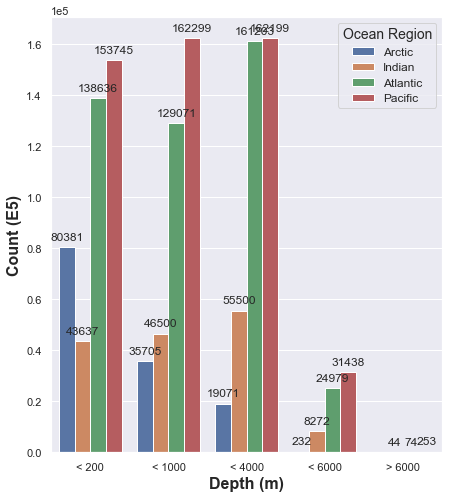

In [16]:
#fig size 
plt.figure(figsize=(7, 8))
ax=sns.countplot(df['depthBinned'], hue="Ocean Region", data = df);
sns.set(style='darkgrid',)
plt.xlabel('Depth (m)',fontsize=16,fontweight='bold');plt.ylabel('Count (E5)',fontsize=16,fontweight='bold')
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title

#bar annotations 
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()    

In [17]:
i=df.groupby(['Ocean Region','month']).size().reset_index(name='counts')

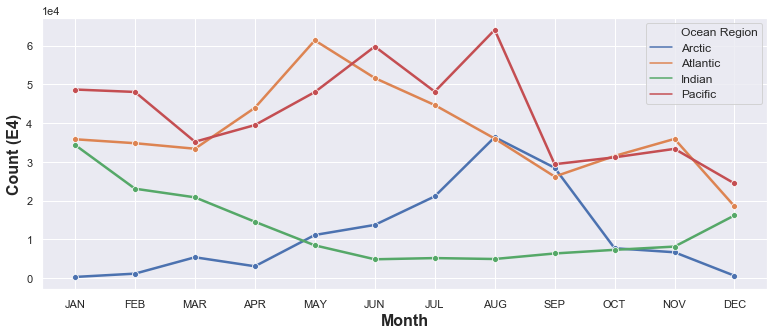

In [18]:

#fig size 
plt.figure(figsize=(13, 5))
ax=sns.lineplot(i['month'],i['counts'],hue="Ocean Region", data = i, marker="o", linewidth=2.5);
sns.set(style='darkgrid',)
plt.xlabel('Month',fontsize=16,fontweight='bold')
plt.ylabel('Count (E4)',fontsize=16,fontweight='bold')
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title

#bar annotations 
#for p in ax.patches:
#    ax.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xticks(np.arange(1,13, 1.0));labels = [item.get_text() for item in ax.get_xticklabels()]
labels= ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

ax.set_xticklabels(labels)

plt.show()  

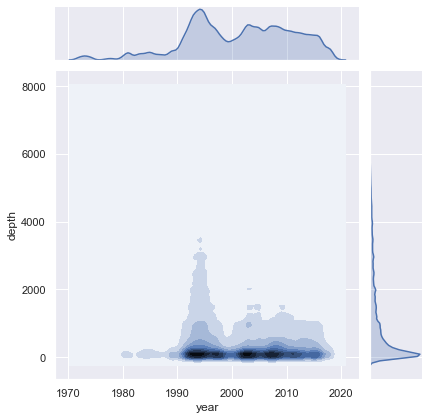

In [19]:
sns.jointplot(x=df['year'], y=df['depth'], kind="kde", color="b");
sns.set(style='darkgrid',)
plt.show()    

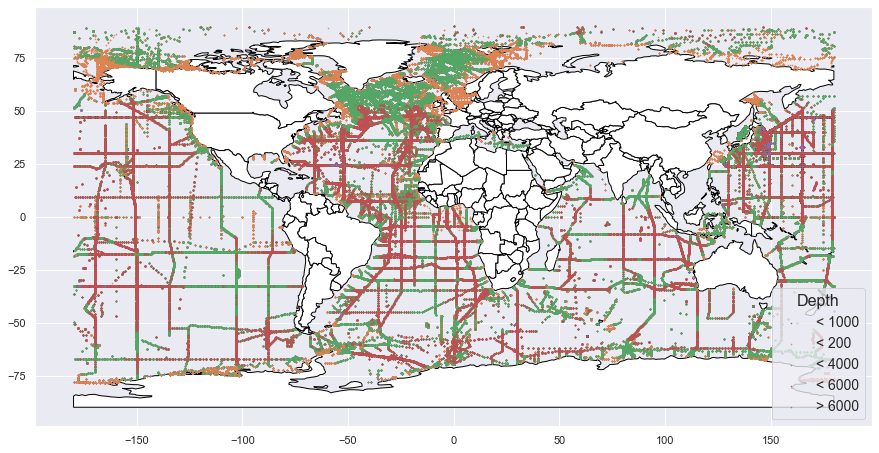

In [20]:
fig, axe = plt.subplots(1, 1,figsize=(15, 10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(color='white', ax=axe,edgecolor='black', )

by_ocean = df.groupby("depthBinned")
for d, frame in by_ocean: 
    axe.scatter(frame.longitude,frame.latitude,s=.3,label=d);

plt.legend(title='Depth',fontsize= 14)

plt.setp(axe.get_legend().get_title(), fontsize='16') # for legend title
plt.show()

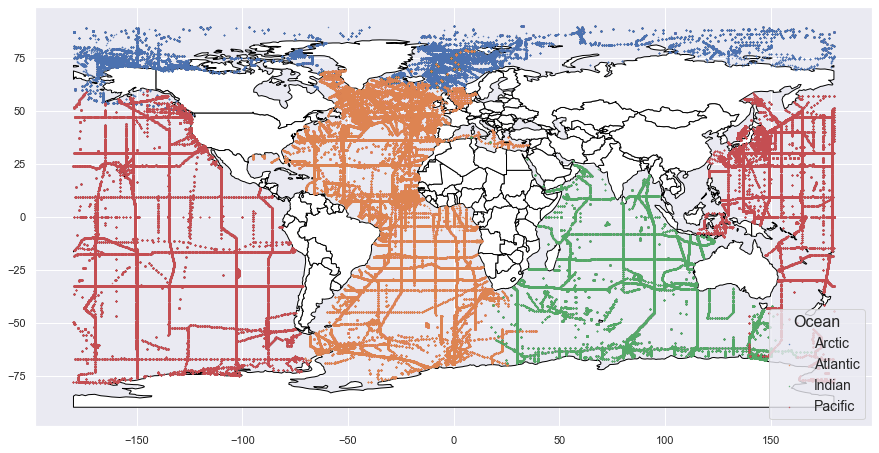

In [21]:
fig, axe = plt.subplots(1, 1,figsize=(15, 10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(color='white', ax=axe,edgecolor='black', )

by_ocean = df.groupby("Ocean Region")

for state, frame in by_ocean: 
    axe.scatter(frame.longitude,frame.latitude,s=.2,label=state);

plt.legend(title='Ocean',fontsize= 14)
plt.setp(axe.get_legend().get_title(), fontsize='16') # for legend title
plt.show()

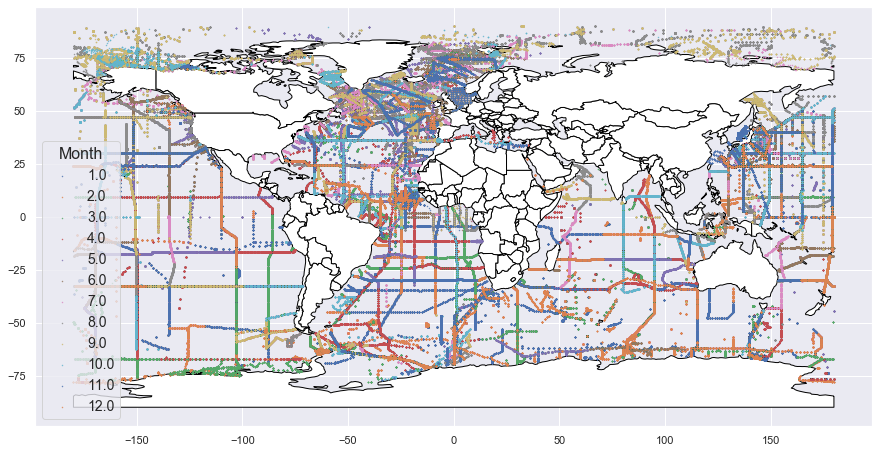

In [22]:
fig, axe = plt.subplots(1, 1,figsize=(15, 10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(color='white', ax=axe,edgecolor='black', )

by_ocean = df.groupby("month")

for state, frame in by_ocean: 
    axe.scatter(frame.longitude,frame.latitude,s=.2,label=state);

plt.legend(title='Month',fontsize= 14)
plt.setp(axe.get_legend().get_title(), fontsize='16') # for legend title

plt.show()

## Getting the dataset ready for training models

export final dataframe for use in next notebook "Organization and Training"

In [10]:
df.to_csv('C:\\Users\\ossan\\DATA606\\DATA\\mergedOceans_CLEANED.csv',index=False)

In [13]:
df.shape

(1253239, 60)

## Make gif of cruise locations looping on years. 

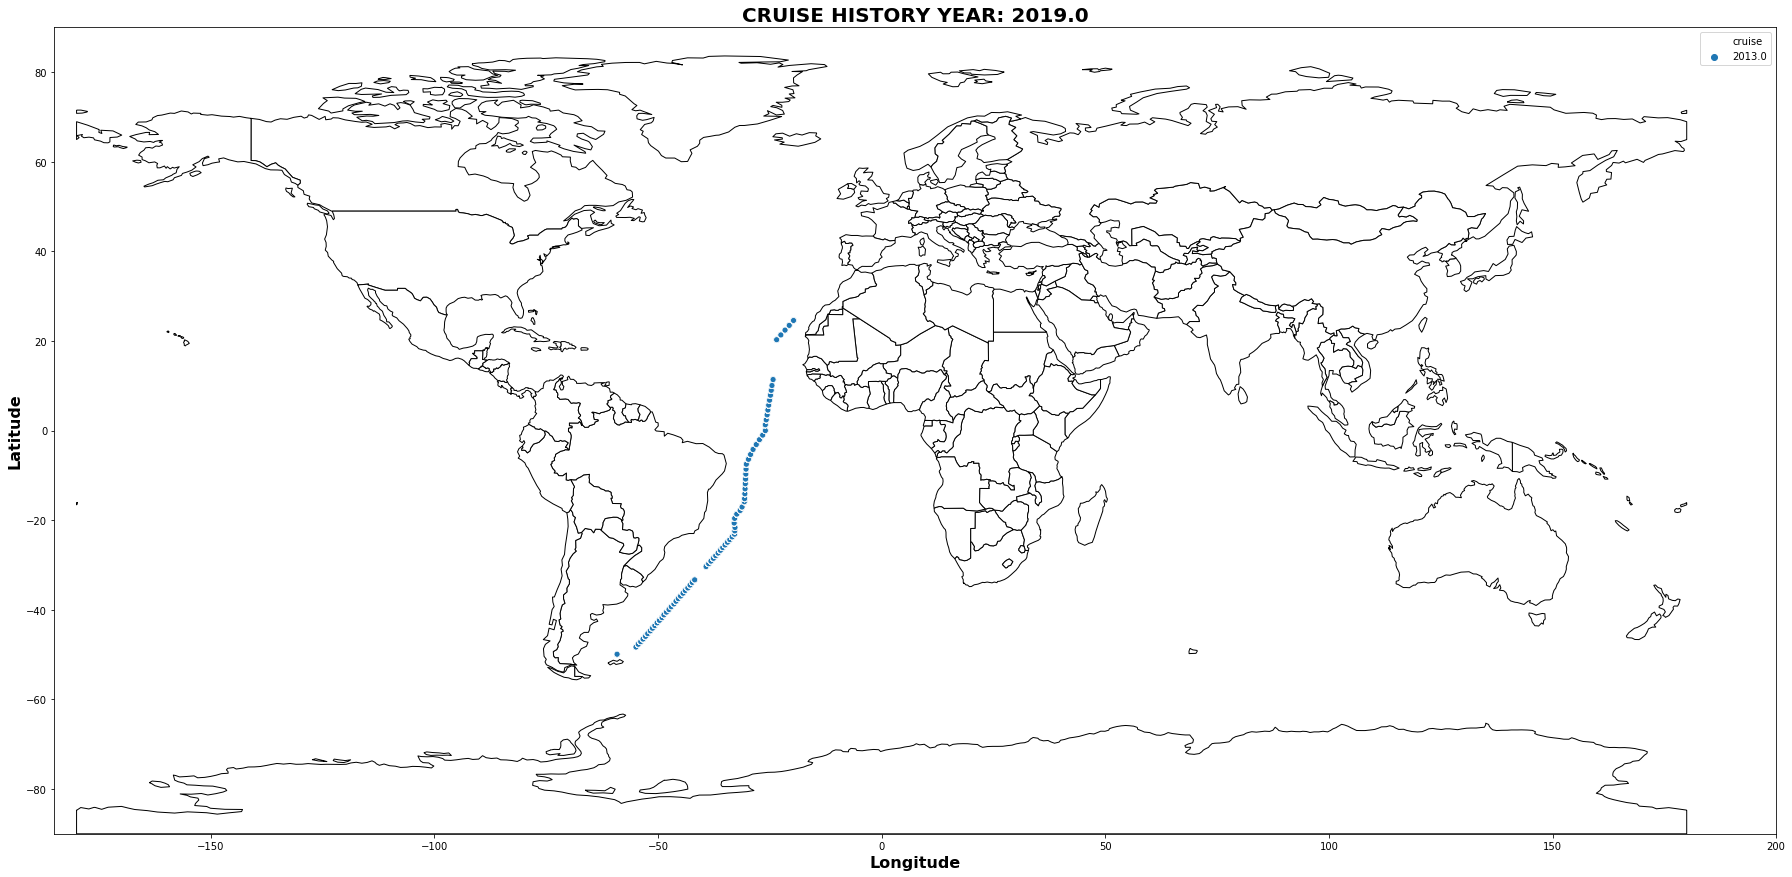

In [15]:
aa=df.groupby(["year"])


for d, frame in aa:
    fig, axe = plt.subplots(1, 1,figsize=(25,20))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(color='white', ax=axe,edgecolor='black', )
    sns.scatterplot(frame.longitude,frame.latitude, hue=(frame.cruise).astype('category'));
    plt.ylim((-90,90));plt.xlim((-185,200))   
    plt.xlabel('Longitude',fontsize=16,fontweight='bold'); plt.ylabel('Latitude',fontsize=16,fontweight='bold')
    axe.legend(loc='upper right')
    display.clear_output(wait=True)
    #time.sleep()
    plt.title(('CRUISE HISTORY YEAR: ' +str(d)),fontsize=20,fontweight='bold')
    plt.tight_layout()
    fig.savefig('C:\\Users\\ossan\\DATA606\\VIDEO1\\' + str(d) + '.png')
    plt.show()


## Make a video of the plot 
Source: https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/

In [17]:
# Video Generating function 
def generate_video(): 
    image_folder = 'C:\\Users\\ossan\\DATA606\\VIDEO1\\'# make sure to use your folder 
    video_name = 'Yearly.avi'
    os.chdir("C:\\Users\\ossan\\DATA606\\") 
      
    images = [img for img in os.listdir(image_folder) 
              if img.endswith(".jpg") or img.endswith(".jpeg") or img.endswith("png")] 

    frame = cv2.imread(os.path.join(image_folder, images[0])) ;height, width, layers = frame.shape   
    video = cv2.VideoWriter(video_name, 0, 1, (width, height))  
  
    # Appending the images to the video one by one 
    for image in images:  
        video.write(cv2.imread(os.path.join(image_folder, image)))  
      
    # Deallocating memories taken for window creation 
    cv2.destroyAllWindows()  
    video.release()  # releasing the video generated 
  
  
# Calling the generate_video function 
generate_video() 

['1972.0.png', '1973.0.png', '1974.0.png', '1977.0.png', '1978.0.png', '1980.0.png', '1981.0.png', '1982.0.png', '1983.0.png', '1984.0.png', '1985.0.png', '1986.0.png', '1987.0.png', '1988.0.png', '1989.0.png', '1990.0.png', '1991.0.png', '1992.0.png', '1993.0.png', '1994.0.png', '1995.0.png', '1996.0.png', '1997.0.png', '1998.0.png', '1999.0.png', '2000.0.png', '2001.0.png', '2002.0.png', '2003.0.png', '2004.0.png', '2005.0.png', '2006.0.png', '2007.0.png', '2008.0.png', '2009.0.png', '2010.0.png', '2011.0.png', '2012.0.png', '2013.0.png', '2014.0.png', '2015.0.png', '2016.0.png', '2017.0.png', '2018.0.png', '2019.0.png']


### make gif of plot 

In [16]:
import os
i=os.listdir('C:\\Users\\ossan\\DATA606\\VIDEO1\\' )
jpg=[]
for x in i: 
    jpg.append('C:\\Users\\ossan\\DATA606\\VIDEO1\\'+x)

import imageio
images = []
for filename in jpg:
    images.append(imageio.imread(filename))
imageio.mimsave('C:\\Users\\ossan\\DATA606\\yearCruises.gif', images,format='GIF',duration=2)

### attempt interactive figure, not behaving with sort by year 

In [ ]:
%matplotlib inline

#cannot REODER DATES WITHOUT DATA LOSS? 
df2 = df 
df2['cruise'] = df2['cruise'].astype('category')
#df2=df2.sort_values(by=['year'])
fig = go.Figure()

fig = px.scatter_geo(df2,lon="longitude", lat="latitude", animation_frame="year", 
                animation_group="cruise",# size="pop",
                 color="cruise", hover_name="cruise",width=800, height=400)
          # log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

#fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

### ploty.graphs-[long load time] cell is as type markdown 

import plotly.graph_objects as go
import plotly.express as px

fig =px.scatter_geo(
        lon = ART['longitude'],
        lat = ART['latitude'],
        #text = stations['NOAA_id'],
        color = ART['year'])

fig.update_layout(title = 'Arctic Ocean')
fig.update_geos(fitbounds="locations")
fig.show()

import plotly.graph_objects as go
import plotly.express as px

fig =px.scatter_geo(lon = ART['longitude'],  lat = ART['latitude'],
        #text = stations['NOAA_id'],
    color = ART['year'] )

fig.update_layout(title = 'Merged File',
       # geo_scope='world',)
       
fig.show()

### SNS pairplot (long load time) 

sns.pairplot(df.drop(columns=['cruise', 'station', 'theta','gamma','cast', 'year', 'month', 'day', 'hour', 'minute',
                              'Ocean Region','depthBinned', 'bottomdepth', 'phtsinsitutp','maxsampdepth', 'bottle',
                      'sigma0', 'sigma1', 'sigma2', 'sigma3', 'sigma4','cfc11', 'pcfc11', 'cfc12',
       'pcfc12', 'cfc113', 'pcfc113', 'ccl4', 'pccl4', 'sf6', 'psf6', 'c13',
       'c14','fco2','fco2temp','h3', 'he3', 'he', 'neon', 'o18','nitrate', 'nitrite', 'silicate', 'phosphate']))